## Imports and paths

In [24]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

from mrcnn import config, utils, visualize
import mrcnn.model as model_
from mrcnn.config import Config
from mrcnn.model import log

import warnings 
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline 


In [25]:
# Data Path
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

In [26]:
# Get train and test IDs
train_ids = os.listdir(TRAIN_PATH)
test_ids = os.listdir(TEST_PATH)

In [27]:
# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [28]:
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [29]:
class NucleusConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides values specific
    to the dataset.
    """
    # Give the configuration a recognizable name
    NAME = "Nucleus"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU. Batch size is (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + nucleus

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 64, 128, 256)  # anchor size in pixels

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 800

    # set number of epoch
    STEPS_PER_EPOCH = 200

    # set validation steps 
    VALIDATION_STEPS = 50
    
config = NucleusConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Loading data

In [30]:
class NucleusDataset(utils.Dataset):
    
    def load_nucleus_data(self, mode):
        
        # Add classes
        self.add_class("Nucleus", 1, "nucleus") # first class i.e. Background has already been initialised, we add nucleus
        

        if mode == "train":  
            for n, id_ in enumerate(train_ids):
                if n < int(len(train_ids) * 0.9):
                    path = TRAIN_PATH + id_
                    img_path = path + '/images/'
                    self.add_image("Nucleus", image_id=id_, path=img_path)
              
        if mode == "val":   
            for n, id_ in enumerate(train_ids):
                if n >= int(len(train_ids) * 0.9):
                    path = TRAIN_PATH + id_
                    img_path = path + '/images/'
                    self.add_image("Nucleus", image_id=id_, path=img_path)
        
        if mode == "test":  
            for n, id_ in enumerate(test_ids):
                if n < int(len(test_ids)):
                    path = TEST_PATH + id_
                    img_path = path + '/images/'
                    self.add_image("Nucleus", image_id=id_, path=img_path)
                    
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        
        info = self.image_info[image_id]
        info = info.get("id")
       
        path = TRAIN_PATH + info
        img = imread(path + '/images/' + info + '.png')[:,:,:3]
        img = resize(img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
       
        return img
    
    def image_reference(self, image_id):
        """Return the Nucleus data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "Nucleus":
            return info["Nucleus"]
        else:
            super(self.__class__).image_reference(self, image_id)
            
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        
        info = self.image_info[image_id]
        info = info.get("id")
        
        path = TRAIN_PATH + info
        number_of_masks = len(os.listdir(path + '/masks/'))
        mask = np.zeros([config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], number_of_masks], dtype=np.uint8)
        
        # Collect masks
        iterator = 0
        for mask_file in os.listdir(path + '/masks/'):
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = resize(mask_, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
            mask[:, :, iterator] = mask_
            iterator += 1
            
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(number_of_masks-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
            
        # Map class names to class IDs.
        class_ids = np.ones((number_of_masks,), dtype=int)
        
        return mask, class_ids.astype(np.int32)

In [31]:
# Training dataset
dataset_train = NucleusDataset()
dataset_train.load_nucleus_data("train")
dataset_train.prepare()

# Validation dataset
dataset_val = NucleusDataset()
dataset_val.load_nucleus_data("val")
dataset_val.prepare()

# Testing dataset
dataset_test = NucleusDataset()
dataset_test.load_nucleus_data("test")
dataset_test.prepare()

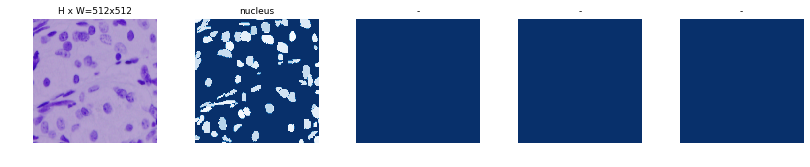

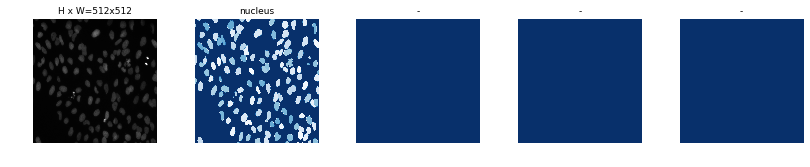

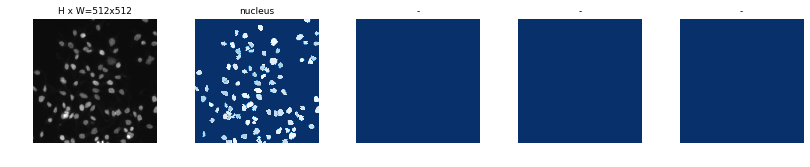

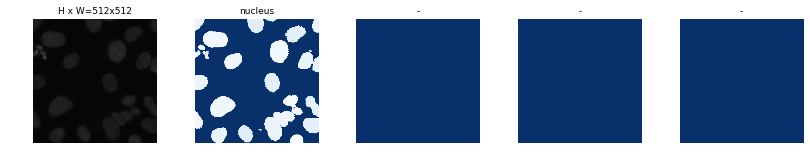

In [32]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [33]:
# Create model in training mode
model = model_.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

## Define model

In [34]:
# We don't want to train the model from scratch, therefore we initialise weights as per some previously trained data like COCO dataset
init_with = "coco"  # imagenet, coco, or last

model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

## Training

In [139]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE, 
            epochs=10, 
            layers='heads') # heads because we're freezing all the backbone layers and training only the randomly initialized layers


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/logs/nucleus20190106T2130/mask_rcnn_nucleus_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4       

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
200/200 [==============================] - 371s 2s/step - loss: 2.1133 - rpn_class_loss: 0.2358 - rpn_bbox_loss: 0.9745 - mrcnn_class_loss: 0.0850 - mrcnn_bbox_loss: 0.4308 - mrcnn_mask_loss: 0.3872 - val_loss: 1.2112 - val_rpn_class_loss: 0.0682 - val_rpn_bbox_loss: 0.7901 - val_mrcnn_class_loss: 0.0709 - val_mrcnn_bbox_loss: 0.1336 - val_mrcnn_mask_loss: 0.1483
Epoch 2/10
200/200 [==============================] - 329s 2s/step - loss: 1.2126 - rpn_class_loss: 0.1065 - rpn_bbox_loss: 0.5480 - mrcnn_class_loss: 0.1273 - mrcnn_bbox_loss: 0.1944 - mrcnn_mask_loss: 0.2365 - val_loss: 0.8298 - val_rpn_class_loss: 0.0501 - val_rpn_bbox_loss: 0.4955 - val_mrcnn_class_loss: 0.0857 - val_mrcnn_bbox_loss: 0.0716 - val_mrcnn_mask_loss: 0.1270
Epoch 3/10
200/200 [==============================] - 332s 2s/step - loss: 0.9985 - rpn_class_loss: 0.0712 - rpn_bbox_loss: 0.4247 - mrcnn_class_loss: 0.1392 - mrcnn_bbox_loss: 0.1599 - mrcnn_mask_loss: 0.2034 - val_loss: 0.7826 - val_rpn_class_l

In [0]:
model_path = os.path.join(ROOT_DIR, "mask_rcnn_nucleus_seg.h5")
model.keras_model.save_weights(model_path) #saving the trained weights

## Inference

In [35]:
class InferenceConfig(NucleusConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = model_.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)

# Get path to saved weights
model_path = os.path.join(ROOT_DIR, "mask_rcnn_nucleus_seg.h5")

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:\Users\mydig\Desktop\Python Notebooks\Work\github\nuclei-segmentation\mask_rcnn_nucleus_seg.h5


original_image           shape: (512, 512, 3)         min:   10.00000  max:  176.93750  float64
image_meta               shape: (14,)                 min:    0.00000  max:  512.00000  int32
gt_class_id              shape: (13,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (13, 4)               min:    5.00000  max:  512.00000  int32
gt_mask                  shape: (512, 512, 13)        min:    0.00000  max:  255.00000  uint8


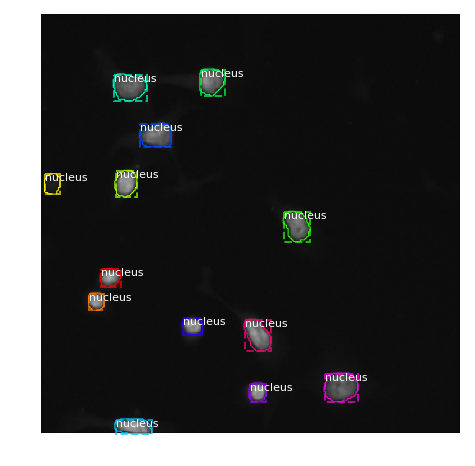

In [36]:
# Test on a random image from validation set
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =  model_.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

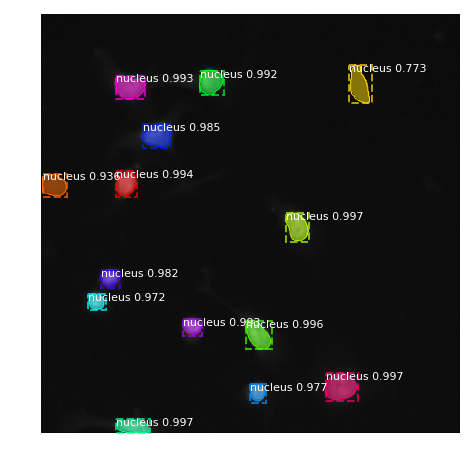

In [37]:
results = model.detect([original_image], verbose=0)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], figsize=(8, 8))

## Testing

In [38]:
X_test = np.zeros((len(test_ids), config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], 3), dtype=np.uint8)
sizes_test = []
_test_ids = []

print('Getting and resizing test images ... ')

for n, id_ in enumerate(test_ids):
    _test_ids.append([id_])
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:3]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
    X_test[n] = img

Getting and resizing test images ... 


checking a test image with masks ...


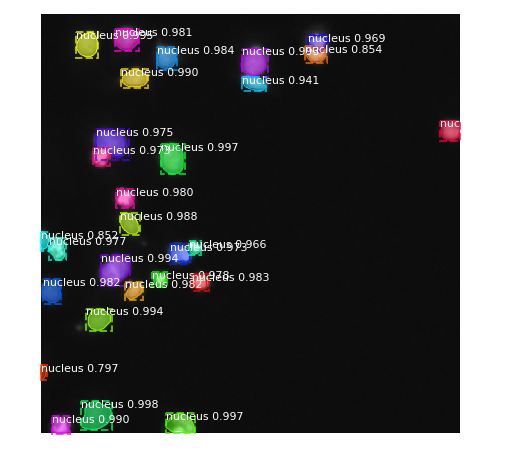

In [48]:
print("checking a test image with masks ...")
results = model.detect([X_test[13]], verbose=0)

r = results[0]
visualize.display_instances(X_test[13], r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], figsize=(8,8))

In [40]:
# Calculating mAP for validation set images
image_ids = dataset_val.image_ids
APs = []

for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask = model_.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)
    molded_images = np.expand_dims(model_.mold_image(image, inference_config), 0)
    
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    # Compute AP
    AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.8243012031565607


In [41]:
# Calculating mAP for training set images
image_ids = dataset_train.image_ids
APs = []

for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask = model_.load_image_gt(dataset_train, inference_config, image_id, use_mini_mask=False)
    molded_images = np.expand_dims(model_.mold_image(image, inference_config), 0)
    
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    # Compute AP
    AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.7970811553311001
